20:15:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:15:20 - cmdstanpy - INFO - CmdStan done processing.
20:15:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:15:45 - cmdstanpy - INFO - CmdStan done processing.
20:15:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model2_fit.stan', line 19, column 2 to column 46)
Consider re-running with show_console=True if the above output is unclear!
20:15:45 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 26 divergent transitions (2.6%)
	Chain 2 had 21 divergent transitions (2.1%)
	Chain 3 had 55 divergent transitions (5.5%)
	Chain 4 had 297 divergent transitions (29.7%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.



📊 WAIC comparison:
         rank   elpd_waic     p_waic  elpd_diff    weight         se  \
Model 1     0 -394.875034  16.657915   0.000000  0.650456  19.059741   
Model 2     1 -395.489086  17.211663   0.614052  0.349544  19.058146   

              dse  warning scale  
Model 1  0.000000     True   log  
Model 2  0.327111     True   log  


/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


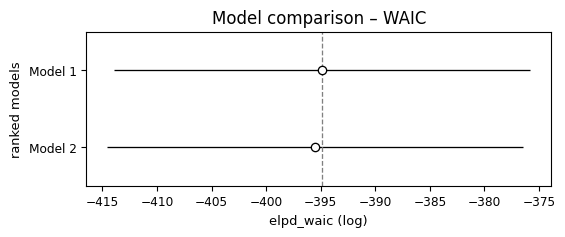

📊 PSIS-LOO comparison:
         rank    elpd_loo      p_loo  elpd_diff    weight         se  \
Model 1     0 -395.099567  16.882448   0.000000  0.641907  20.893161   
Model 2     1 -395.703294  17.425872   0.603727  0.358093  20.890743   

              dse  warning scale  
Model 1  0.000000    False   log  
Model 2  0.314957     True   log  


/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


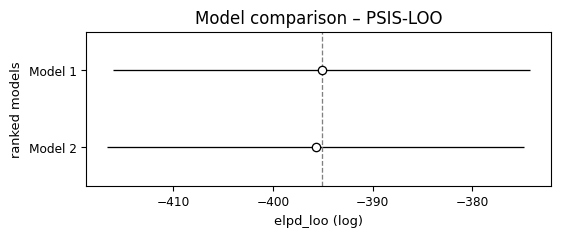

In [2]:
import pandas as pd
import numpy as np
from cmdstanpy import CmdStanModel
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# === Wczytaj dane z CSV ===
X = pd.read_csv("X.csv").values.astype(np.float32)
y = pd.read_csv("y.csv")["default"].values.astype(np.int32)
purpose = pd.read_csv("purpose.csv")["purpose"]

N, K = X.shape

# === Przygotuj dane do model1 (bez efektów losowych) ===
stan_data1 = {
    "N": N,
    "K": K,
    "X": X.tolist(),
    "y": y.tolist()
}

# === Przygotuj dane do model2 (z efektami losowymi dla 'purpose') ===
le = LabelEncoder()
group_id = le.fit_transform(purpose) + 1  # Stan uses 1-based indexing
G = len(le.classes_)

stan_data2 = {
    "N": N,
    "K": K,
    "X": X.tolist(),
    "y": y.tolist(),
    "G": G,
    "group_id": group_id.tolist()
}

# === Wczytaj modele Stan ===
model1 = CmdStanModel(stan_file="model1_fit.stan")
model2 = CmdStanModel(stan_file="model2_fit.stan")

# === Fitowanie modeli ===
fit1 = model1.sample(data=stan_data1, chains=4, iter_warmup=1000, iter_sampling=1000, seed=42)
fit2 = model2.sample(data=stan_data2, chains=4, iter_warmup=1000, iter_sampling=1000, seed=42)

# === Konwersja wyników do formatu ArviZ ===
idata1 = az.from_cmdstanpy(posterior=fit1)
idata2 = az.from_cmdstanpy(posterior=fit2)

# === Porównanie modeli – WAIC ===
waic_comparison = az.compare(
    {"Model 1": idata1, "Model 2": idata2},
    ic="waic",
    method="BB-pseudo-BMA"
)
print("📊 WAIC comparison:")
print(waic_comparison)
az.plot_compare(waic_comparison)
plt.title("Model comparison – WAIC")
plt.show()

# === Porównanie modeli – PSIS-LOO ===
loo_comparison = az.compare(
    {"Model 1": idata1, "Model 2": idata2},
    ic="loo",
    method="BB-pseudo-BMA"
)
print("📊 PSIS-LOO comparison:")
print(loo_comparison)
az.plot_compare(loo_comparison)
plt.title("Model comparison – PSIS-LOO")
plt.show()

In [2]:
loo1 = az.loo(idata1)
loo2 = az.loo(idata2)
print(loo1.pareto_k)
print(loo2.pareto_k)

<xarray.DataArray 'pareto_shape' (log_lik_dim_0: 1000)> Size: 8kB
array([ 1.83488300e-01, -4.90618619e-02,  3.71999684e-02,  2.88596811e-01,
        9.58473781e-02, -5.36517276e-02, -1.41042117e-01, -1.29981603e-02,
       -8.26050017e-02,  8.33158509e-03,  5.97307600e-02, -1.42426355e-02,
        1.49735818e-02,  6.43467530e-03,  4.83204268e-02,  1.47285014e-01,
        7.25258327e-02, -1.37180999e-01, -1.12903185e-02, -4.08858250e-02,
        5.93952225e-03, -5.75456848e-02,  2.01198409e-01,  5.16076676e-02,
        6.30087113e-02, -4.05202681e-02,  9.10688451e-02, -1.09271401e-01,
        5.33630463e-02, -3.60121221e-03,  2.29565696e-01, -4.80976569e-02,
       -7.86567656e-02,  6.84108357e-02,  3.33813409e-02, -3.70715896e-02,
        3.27856641e-02, -1.42536103e-03, -4.78938169e-02, -5.45141052e-02,
        2.38598434e-02,  1.04316613e-01,  1.65635798e-01,  4.25931592e-02,
       -5.91717572e-02,  9.98540492e-02,  8.99289541e-02,  6.19034792e-02,
        8.82083917e-02,  4.1587082

/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
